# Prediction of if the Item is purchase from the Ads

This notebook is a work flow for various Python-based machine learning model for predicting if the item is purchase from the ad

Going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Model Evaluation

# 1. Problem Definition

How we can use various python based Machine Learning Model to and the given parameters to predict the if th ad is shown will the item be purchase?


# 2. Data

Data set from: https://www.kaggle.com/d4rklucif3r/social-network-ads

The Dataset used in these models tells about whether a person of certain age having certain income purchases a product or not.
We need to predict whether a targeted audience will purchase the product or not.

# 3. Evaluation

It will be done with the Classification Metrics.

# 4. Features

## Input /  Features
    1. Age - Age of the Person
    2. EstimatedSalary - Estimated Salary of Person

## Output / Label
    3. PurchasedItem - Purchased or Not

## Standard Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# local
df = pd.read_csv('Social_Network_Ads.csv')


## Data Exporation

In [3]:
df

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0
...,...,...,...
395,46,41000,1
396,51,23000,1
397,50,20000,1
398,36,33000,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Age              400 non-null    int64
 1   EstimatedSalary  400 non-null    int64
 2   Purchased        400 non-null    int64
dtypes: int64(3)
memory usage: 9.5 KB


In [5]:
df.describe()

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


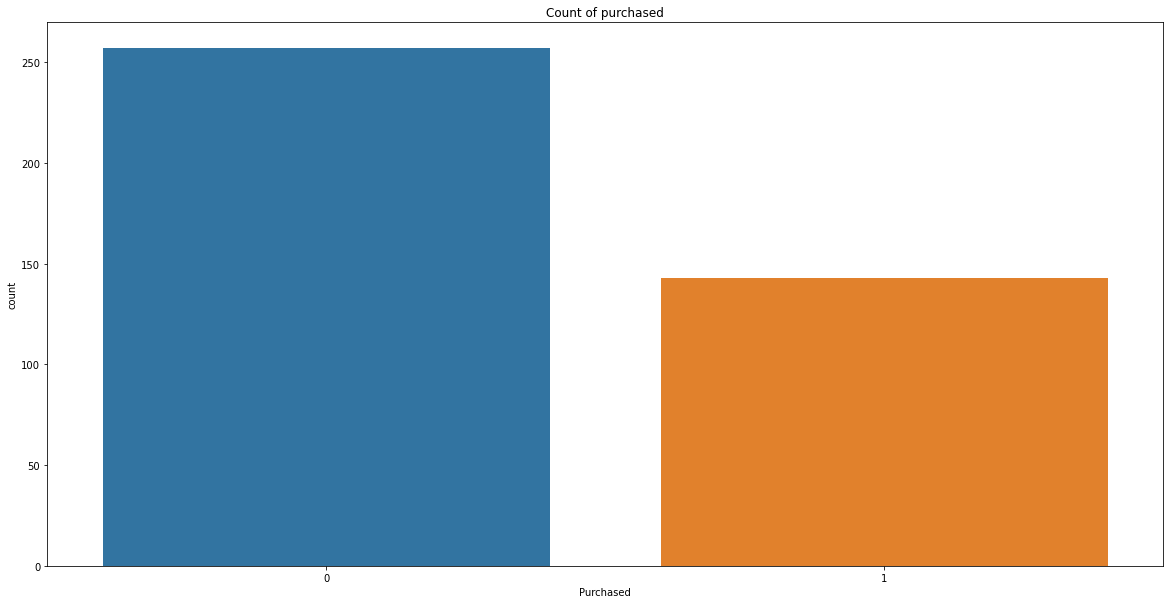

In [6]:
plt.figure(figsize=(20,10))
plt.title('Count of purchased')
sns.countplot(data=df,x='Purchased');

It looks like a little in-balance in the dataset

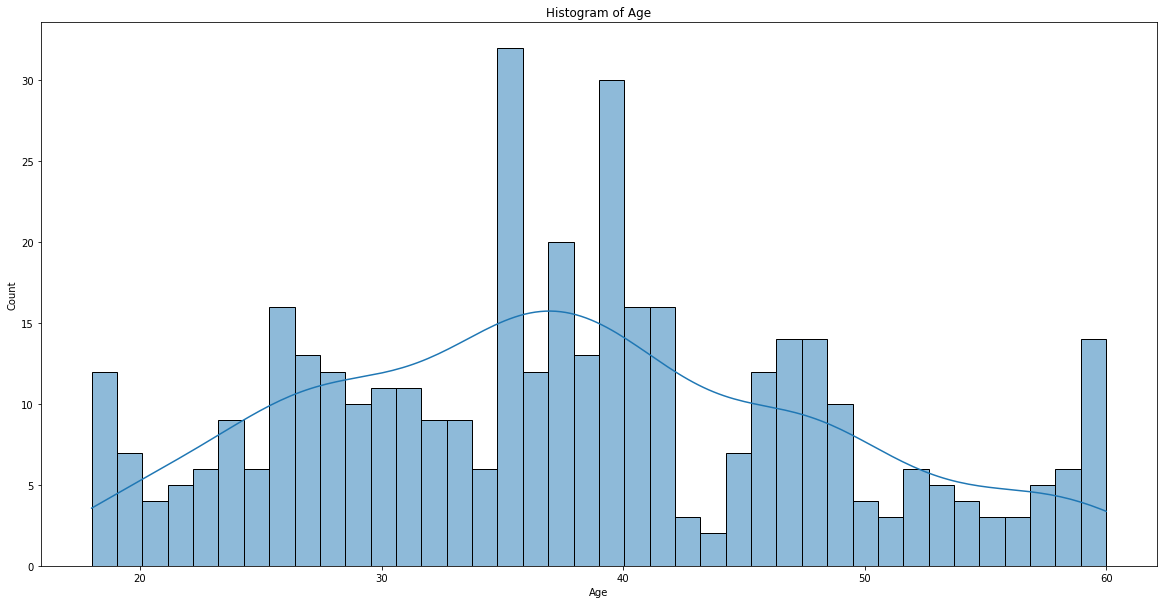

In [7]:
plt.figure(figsize=(20,10))
plt.title('Histogram of Age')
sns.histplot(data=df,x='Age',bins=40, kde=True);

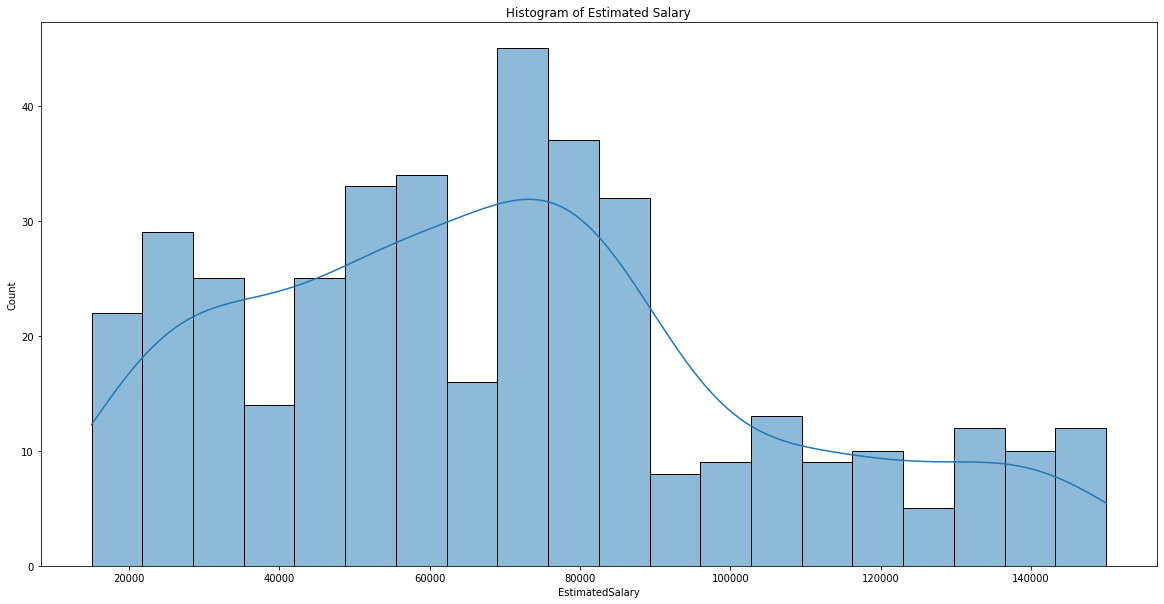

In [10]:
plt.figure(figsize=(20,10))
plt.title('Histogram of Estimated Salary')
sns.histplot(data=df,x='EstimatedSalary',bins=20, kde=True);

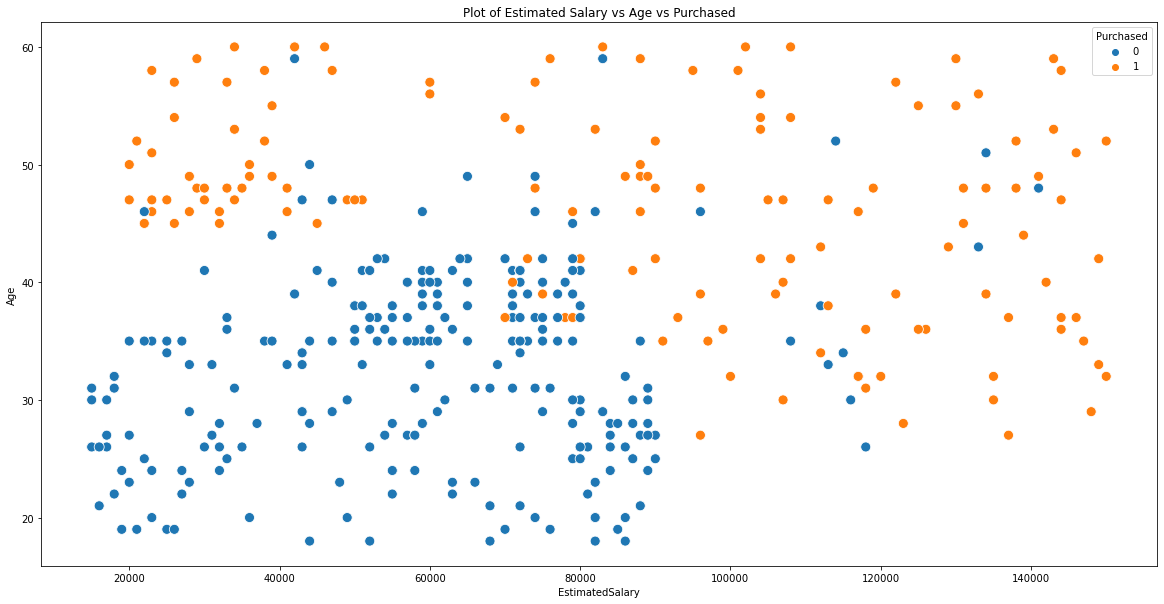

In [8]:
plt.figure(figsize=(20,10))
plt.title('Plot of Estimated Salary vs Age vs Purchased')
sns.scatterplot(data=df,x='EstimatedSalary',y= 'Age', hue='Purchased', s=100);

<AxesSubplot:title={'center':'Heat map of Correlation'}>

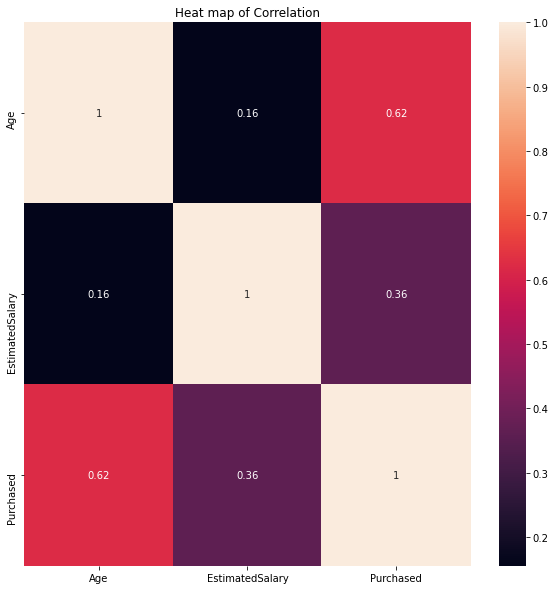

In [9]:
plt.figure(figsize=(10,10))
plt.title('Heat map of Correlation')
sns.heatmap(data=df.corr(), annot= True)

# 5. Modelling

In [10]:
df.head()

,Age,EstimatedSalary,Purchased
0,19,19000,0
1,35,20000,0
2,26,43000,0
3,27,57000,0
4,19,76000,0


In [11]:
df.isnull().sum()

Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [12]:
X = df.drop('Purchased', axis=1)
y = df['Purchased']

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model imports

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# from xgboost import XGBClassifier, XGBRFClassifier

## Baseline Modelling

In [18]:
def fit_and_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    
    model_scores = {}
    
    for name, model in models.items():
        model.fit(X_train,y_train)
        model_scores[name] = model.score(X_test,y_test)

    model_scores = pd.DataFrame(model_scores, index=['Score']).transpose()
    model_scores = model_scores.sort_values('Score')
        
    return model_scores

In [20]:
models = {'LogisticRegression': LogisticRegression(max_iter=10000),
          'KNeighborsClassifier': KNeighborsClassifier(),
          'SVC': SVC(),
          'DecisionTreeClassifier': DecisionTreeClassifier(),
          'RandomForestClassifier': RandomForestClassifier(),
          'AdaBoostClassifier': AdaBoostClassifier(),
          'GradientBoostingClassifier': GradientBoostingClassifier(),
         }

In [21]:
baseline_model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)

In [22]:
baseline_model_scores.sort_values('Score')

,Score
DecisionTreeClassifier,0.8375
LogisticRegression,0.8625
GradientBoostingClassifier,0.8625
RandomForestClassifier,0.8875
AdaBoostClassifier,0.8875
KNeighborsClassifier,0.9125
SVC,0.9250


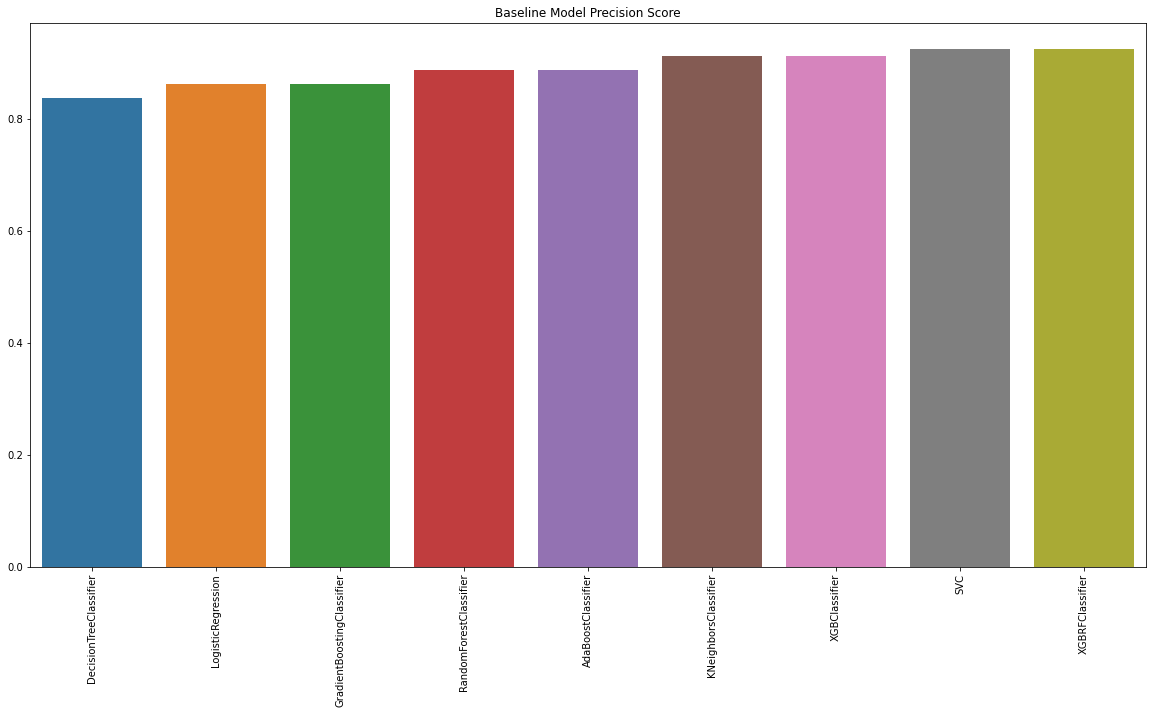

In [24]:
plt.figure(figsize=(20,10))
sns.barplot(data=baseline_model_scores.sort_values('Score').T)
plt.title('Baseline Model Precision Score')
plt.xticks(rotation=90);

From the baseline modeling, we will choose the follow model to have an in-depth look:

1. KNeighborsClassifier 	0.9125
4. SVC 	0.9250

## HyperTuning using Random Search CV

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from warnings import filterwarnings

In [24]:
filterwarnings('ignore')

In [25]:
def randomsearch_cv_scores(models, params, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    
    model_rs_scores = {}
    model_rs_best_param = {}
    
    for name, model in models.items():
        rs_model = RandomizedSearchCV(model,
                                     param_distributions=params[name],
                                     cv=5,
                                     n_iter=20,
                                     verbose=1)
        rs_model.fit(X_train,y_train)
        model_rs_scores[name] = rs_model.score(X_test,y_test)
        model_rs_best_param[name] = rs_model.best_params_
        
    return model_rs_scores, model_rs_best_param

### RandomSearch CV 1

In [27]:
params = {'KNeighborsClassifier' : {'n_neighbors': np.arange(1,100,10)},
          
          'SVC' : {'C': [0.1,0.5,1, 10,100,500], 
                   'kernel':['linear', 'poly', 'rbf','sigmoid'],
                   'gamma':['scale','auto'],
                   'degree':[2,3,4,5,6,7]}
          }
models = {'KNeighborsClassifier': KNeighborsClassifier(),
        
         'SVC': SVC()
         }

In [28]:
model_rs_scores_1, model_rs_best_param_1 = randomsearch_cv_scores(models, params, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [29]:
model_rs_scores_1


{'KNeighborsClassifier': 0.925, 'SVC': 0.925}

In [30]:
model_rs_best_param_1

{'KNeighborsClassifier': {'n_neighbors': 11},
 'SVC': {'kernel': 'rbf', 'gamma': 'scale', 'degree': 7, 'C': 0.1}}

## RandomSearch CV 2

In [32]:
params = {'KNeighborsClassifier' : {'n_neighbors': np.arange(1,15)},
          'XGBClassifier': {'learning_rate': [0.631578947368421],
                            'gamma': [15,20,25],
                            'max_depth': [2],
                            'lambda': [0,1],
                            'alpha' : [0],
                            },
          'XGBRFClassifier': {'learning_rate': [0.47368421052631576],
                              'max_depth': [2],
                              },
          'SVC' : {'C': [0.3,0.4,0.5,0.6,0.7], 
                   'kernel':['rbf'],
                   'gamma':['scale'],
                   'degree':[7,8,9,10,15,20]}
          }
models = {'KNeighborsClassifier': KNeighborsClassifier(),
         'XGBClassifier': XGBClassifier(eval_metric='mlogloss'),
         'XGBRFClassifier': XGBRFClassifier(eval_metric='mlogloss'),
         'SVC': SVC()
         }

In [33]:
model_rs_scores_2, model_rs_best_param_2 = randomsearch_cv_scores(models, params, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [34]:
model_rs_scores_2

{'KNeighborsClassifier': 0.9375,
 'XGBClassifier': 0.9125,
 'XGBRFClassifier': 0.9125,
 'SVC': 0.925}

In [35]:
model_rs_best_param_2

{'KNeighborsClassifier': {'n_neighbors': 9},
 'XGBClassifier': {'max_depth': 2,
  'learning_rate': 0.631578947368421,
  'lambda': 0,
  'gamma': 15,
  'alpha': 0},
 'XGBRFClassifier': {'max_depth': 2, 'learning_rate': 0.47368421052631576},
 'SVC': {'kernel': 'rbf', 'gamma': 'scale', 'degree': 20, 'C': 0.6}}

# 6. Model Evaluting

In [36]:
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve

In [37]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train,y_train)
y_preds = model.predict(X_test)

## Classification Report

In [38]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        52
           1       0.87      0.96      0.92        28

    accuracy                           0.94        80
   macro avg       0.93      0.94      0.93        80
weighted avg       0.94      0.94      0.94        80



## Confusion Matrix

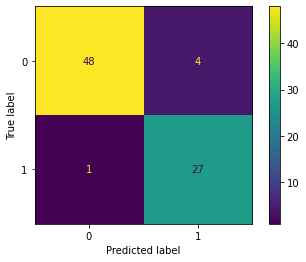

In [39]:
plot_confusion_matrix(model, X_test, y_test)

## ROC Curve

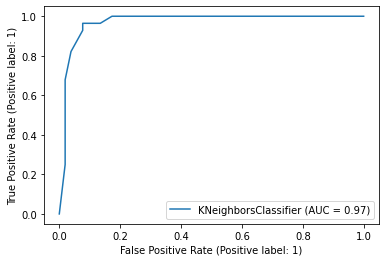

In [40]:
plot_roc_curve(model, X_test,y_test)

Model is preforming at 94% Accuracy